In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
from fastai import *
from fastai import *
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import *
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types
from pathlib import Path

In [3]:
path = Path('/home/jupyter/tutorials/data/')
path.ls()

[PosixPath('/home/jupyter/tutorials/data/data1.zip'),
 PosixPath('/home/jupyter/tutorials/data/training.csv'),
 PosixPath('/home/jupyter/tutorials/data/images'),
 PosixPath('/home/jupyter/tutorials/data/test.csv'),
 PosixPath('/home/jupyter/tutorials/data/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/tutorials/data/models')]

In [4]:
imgpath = path/'images'

In [5]:
df = pd.read_csv(path/'training.csv')
tdf = pd.read_csv(path/'training.csv')
df = df.set_index('image_name')
tdf['image_name'] = str(imgpath) +"/"+ tdf['image_name']
tdf = tdf.set_index('image_name')
len(df)

14000

# Creating Data Bunch

In [6]:
SZ = 229
BS = 32
NUM_WORKERS = 12

In [7]:
def fn2bbox(fn):
    im_width, im_height = PIL.Image.open(fn).size
    row = tdf.loc[fn]
    return [
        np.clip(row['y2'],0,im_height),
        np.clip(row['x2'],0,im_width),
        np.clip(row['y1'],0,im_height),
        np.clip(row['x1'],0,im_width)
    ]

In [8]:
get_y_func = lambda o :  [[fn2bbox(o)], ['object']]

In [9]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [10]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [11]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(df.index)),path=path,folder = 'images')
        .random_split_by_pct()
        .label_from_func(get_y_func,label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS,collate_fn=bb_pad_collate, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

# Creating CNN

In [12]:
class ObjectDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [13]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [14]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [15]:
learn = Learner(data, ObjectDetector(arch=models.resnet50), loss_func=loss_fn, wd=1e-1)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [16]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

# Training

In [28]:
learn.freeze()

In [17]:
import gc
gc.collect()

333

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 7.43 GiB total capacity; 6.65 GiB already allocated; 20.94 MiB free; 212.54 MiB cached)

In [ ]:
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(30,1e-3)

epoch,train_loss,valid_loss,
1,0.586806,0.563985,0.027136
2,0.341310,0.253523,0.381133
3,0.144578,0.107677,0.699207
4,0.113409,0.089331,0.746681
5,0.092642,0.070807,0.791474
6,0.079606,0.060051,0.820759
7,0.073711,0.053106,0.835218
8,0.068747,0.046063,0.856140
9,0.066312,0.050380,0.839709
10,0.062023,0.048531,0.845558


In [88]:
learn.save('first-299')

In [27]:
import gc
gc.collect()

822

In [91]:
learn = learn.load('first-299')

In [92]:
learn.unfreeze()

In [93]:
lr = 1e-06
lrs = [lr/100,lr/10,lr]

In [94]:
learn.fit_one_cycle(20,lrs,div_factor=20)

epoch,train_loss,valid_loss,
1,0.044014,0.030719,0.902473
2,0.047139,0.031354,0.901003
3,0.045843,0.032330,0.895632
4,0.047633,0.034916,0.888004
5,0.047552,0.034414,0.890626
6,0.045314,0.032382,0.895404
7,0.046247,0.031355,0.900855
8,0.046307,0.032466,0.895311
9,0.044737,0.031455,0.898574
10,0.044155,0.030772,0.902123


In [95]:
learn.save('unfreeze-299')

In [102]:
learn.freeze()

In [103]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


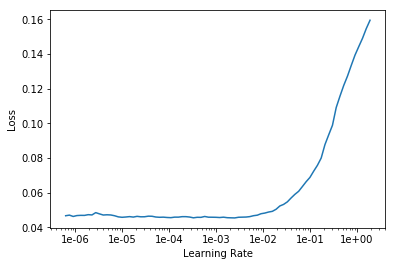

In [104]:
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(30,1e-3)

epoch,train_loss,valid_loss,
1,0.047267,0.031968,0.896313
2,0.047676,0.031884,0.896042
3,0.047094,0.034358,0.888825
4,0.048782,0.033630,0.890841
5,0.051362,0.035161,0.889827
6,0.051375,0.039432,0.873653
7,0.054016,0.041639,0.868690
8,0.053507,0.038322,0.879243
9,0.057414,0.037327,0.883329
10,0.055918,0.041846,0.870269


In [106]:
learn.save('fuf-299')

In [107]:
learn = learn.load('first-299')

In [108]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


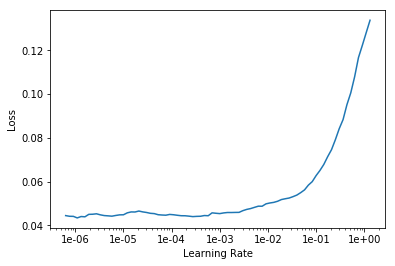

In [109]:
learn.recorder.plot()

In [110]:
learn = learn.load('fuf-299')

In [119]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


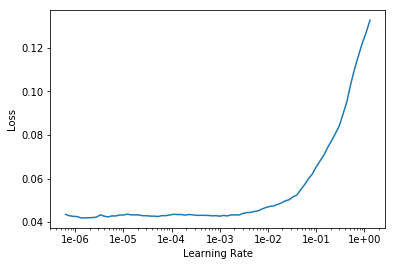

In [120]:
learn.recorder.plot()

In [121]:
learn.fit_one_cycle(30,5e-4)

epoch,train_loss,valid_loss,
1,0.042805,0.030756,0.901055
2,0.042554,0.030108,0.905204
3,0.044810,0.030646,0.902564
4,0.043806,0.030487,0.901138
5,0.044190,0.031409,0.900621
6,0.045172,0.032407,0.895757
7,0.046115,0.032093,0.898188
8,0.047095,0.035132,0.884364
9,0.048720,0.033653,0.893208
10,0.047286,0.034272,0.891356


In [122]:
learn.save('fufff-299')

In [126]:
learn = learn.load('first-299')

In [127]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


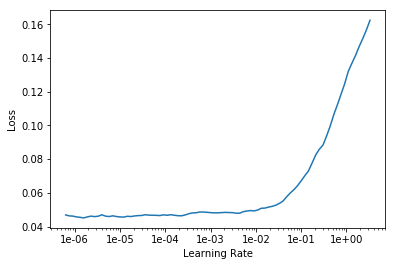

In [128]:
learn.recorder.plot()

In [129]:
learn.fit(30,1e-4)

epoch,train_loss,valid_loss,
1,0.045655,0.033882,0.889529
2,0.046619,0.031695,0.897938
3,0.047080,0.035155,0.886334
4,0.047037,0.032010,0.897306
5,0.045565,0.031489,0.899808
6,0.044792,0.032473,0.895208
7,0.046260,0.030733,0.902466
8,0.044912,0.030782,0.901006
9,0.047407,0.032311,0.898885
10,0.044801,0.032231,0.898453


In [130]:
learn.save('ff-299')

In [38]:
learn = learn.load('fufff-299')

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


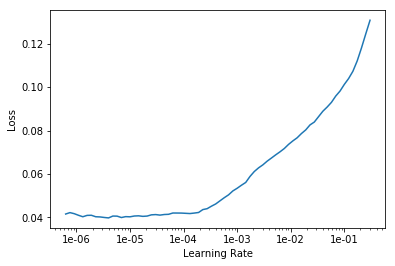

In [40]:
learn.recorder.plot()

In [41]:
learn.fit(40,1e-7)

epoch,train_loss,valid_loss,
1,0.040249,0.024626,0.921451
2,0.040472,0.025188,0.919312
3,0.041980,0.026715,0.912664
4,0.040548,0.026690,0.914717
5,0.041454,0.025955,0.915101
6,0.041949,0.026253,0.915254
7,0.040527,0.026258,0.914801
8,0.042120,0.026721,0.914190
9,0.041651,0.025121,0.919033
10,0.040373,0.025946,0.916920


In [42]:
learn.save('fuffff-299')

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


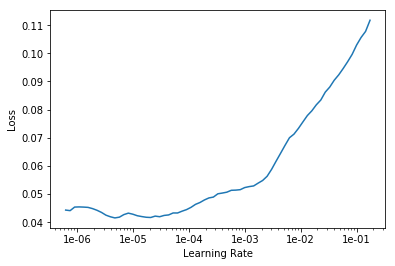

In [51]:
learn.recorder.plot()

In [53]:
learn = learn.load('ff-299')

In [55]:
import gc
gc.collect()

8123

In [56]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


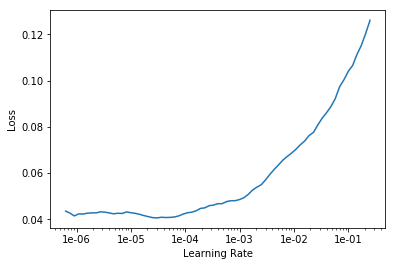

In [57]:
learn.recorder.plot()

In [58]:
lr = 1e-5

In [60]:
learn.fit(20,lr)

epoch,train_loss,valid_loss,
1,0.046125,0.030453,0.901818
2,0.046965,0.030380,0.903569
3,0.044883,0.031755,0.898204
4,0.044223,0.031070,0.900845
5,0.045228,0.035161,0.892577
6,0.045516,0.030089,0.902858
7,0.045953,0.029659,0.906320
8,0.043930,0.033538,0.892842
9,0.044152,0.030522,0.902160
10,0.045324,0.033220,0.895866


KeyboardInterrupt: 

In [ ]:
learn.save('fff-299')

In [70]:
learn = learn.load('fufff-299')

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


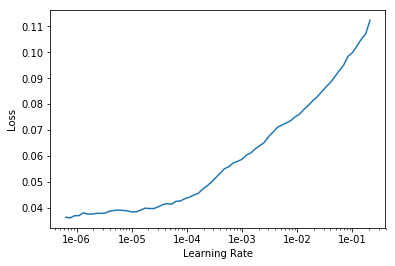

In [63]:
learn.recorder.plot()

In [64]:
lr = 1e-7

In [65]:
lrs = [lr/200,lr/10,lr]

In [71]:
learn.fit_one_cycle(20,1e-7)

epoch,train_loss,valid_loss,
1,0.043087,0.025891,0.915463
2,0.041644,0.027198,0.914284
3,0.041322,0.026876,0.913015
4,0.040743,0.025870,0.917524
5,0.041892,0.027708,0.909449
6,0.040588,0.025800,0.916636
7,0.042247,0.026680,0.915678
8,0.040410,0.026076,0.915002
9,0.042327,0.026030,0.914848
10,0.040473,0.025810,0.917231


In [72]:
learn.save('fufffcf-299')

In [98]:
learn = learn.load('ff-299')

In [99]:
learn.freeze()

In [105]:
import gc
gc.collect()

8561

In [101]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


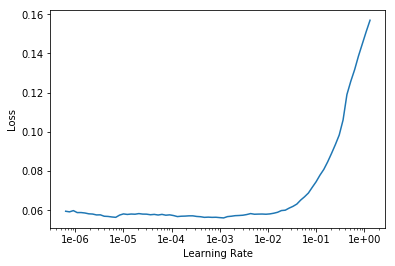

In [102]:
learn.recorder.plot()

In [103]:
learn.fit_one_cycle(30,6e-4,div_factor=20)

epoch,train_loss,valid_loss,
1,0.048354,0.033698,0.891780
2,0.048530,0.032595,0.892681
3,0.046590,0.031398,0.897251
4,0.047489,0.031120,0.899601
5,0.049355,0.031151,0.900577
6,0.050346,0.034724,0.892244
7,0.049214,0.032925,0.892508
8,0.049951,0.033135,0.896291
9,0.051205,0.036638,0.882503
10,0.052556,0.035688,0.888604


In [104]:
learn.save('fff-299')

In [106]:
learn.unfreeze()

In [107]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


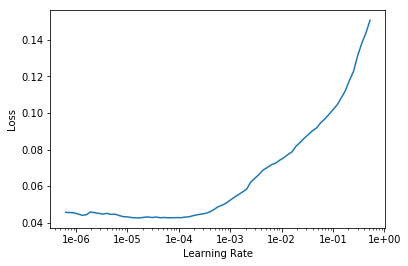

In [108]:
learn.recorder.plot()

In [109]:
lr = 2e-05
lrs = [lr/200,lr/10,lr]

In [110]:
learn.fit_one_cycle(30,lrs,div_factor=20)

epoch,train_loss,valid_loss,
1,0.042109,0.029619,0.905138
2,0.043270,0.030270,0.903752
3,0.043141,0.030262,0.902886
4,0.042585,0.032613,0.896920
5,0.042939,0.030327,0.902903
6,0.042991,0.030743,0.901556
7,0.043611,0.031222,0.898697
8,0.042902,0.030854,0.899327
9,0.042601,0.029669,0.903817
10,0.042840,0.029113,0.907039


In [111]:
learn.save('fffuf-299')

In [30]:
learn = learn.load('fffuf-299')

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


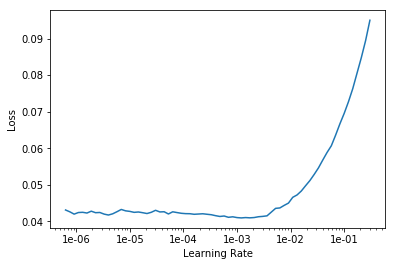

In [32]:
learn.recorder.plot()

In [33]:
lr = 8e-04
lrs = [lr/200,lr/10,lr]

In [34]:
learn.fit_one_cycle(30,lrs,div_factor=20)

epoch,train_loss,valid_loss,
1,0.043060,0.028241,0.906847
2,0.041537,0.027549,0.910459
3,0.042176,0.028014,0.910073
4,0.041917,0.029514,0.903666
5,0.044402,0.029631,0.902966
6,0.044073,0.027566,0.912004
7,0.045087,0.027358,0.912273
8,0.044978,0.029365,0.906375
9,0.044102,0.028776,0.907658
10,0.044356,0.031975,0.894159


In [35]:
learn.save('fffufuf-299')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


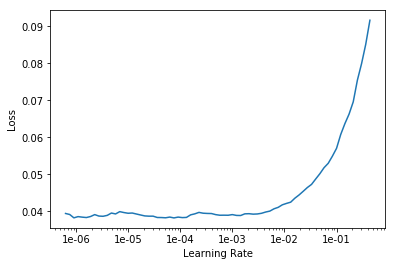

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.freeze()
learn.fit_one_cycle(40,2e-4)

epoch,train_loss,valid_loss,
1,0.040793,0.026470,0.914781
2,0.039929,0.026793,0.914939
3,0.039658,0.026772,0.913640
4,0.040539,0.028408,0.907271
5,0.040476,0.029845,0.903686
6,0.040422,0.027345,0.912499
7,0.040997,0.028694,0.906862
8,0.040960,0.028822,0.907727
9,0.041668,0.027837,0.910990
10,0.040837,0.028527,0.909702


In [38]:
learn.save('fffufuff-299')

In [18]:
learn = learn.load('fffufuff-299')

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


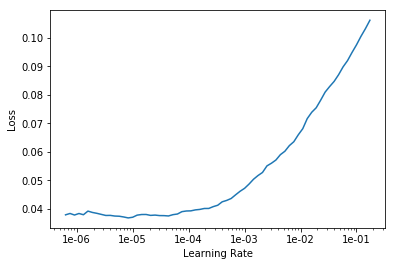

In [20]:
learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(40,slice(1e-5,2e-5))

epoch,train_loss,valid_loss,
1,0.038936,0.025179,0.916193
2,0.039272,0.025273,0.918721
3,0.039503,0.025791,0.915763
4,0.040358,0.025718,0.916497
5,0.041106,0.027954,0.908687
6,0.040147,0.026589,0.912847
7,0.040139,0.034340,0.888538
8,0.041890,0.027498,0.909552
9,0.041069,0.027287,0.910197
10,0.042433,0.030056,0.901681


KeyboardInterrupt: 

In [ ]:
learn.save('fffufuffuf-299')

In [26]:
learn = learn.load('fuffff-299')

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


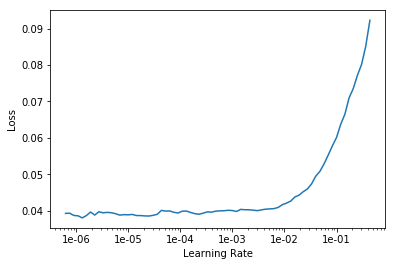

In [39]:
learn.recorder.plot()

In [40]:
learn.freeze()
learn.fit_one_cycle(15,1e-5)

epoch,train_loss,valid_loss,
1,0.040088,0.026724,0.913875
2,0.040016,0.027225,0.913476
3,0.039271,0.027758,0.910058
4,0.039494,0.027599,0.910928
5,0.039958,0.027932,0.910040
6,0.039386,0.027367,0.912021
7,0.039646,0.026764,0.913186
8,0.039036,0.026707,0.914079
9,0.040956,0.026827,0.913903
10,0.039430,0.026961,0.912815


In [41]:
learn.save('fuffffff-299')

In [22]:
import gc
gc.collect()

125

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


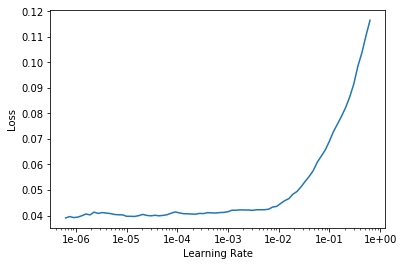

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.unfreeze()
learn.fit_one_cycle(20,slice(5e-6,1e-5))

epoch,train_loss,valid_loss,
1,0.039439,0.027748,0.912544
2,0.039243,0.028184,0.908107
3,0.041595,0.028542,0.908960
4,0.040319,0.026790,0.913808
5,0.041686,0.030362,0.901331
6,0.040486,0.029357,0.907478
7,0.041185,0.028557,0.910123
8,0.040162,0.027437,0.912610
9,0.039611,0.028222,0.909480
10,0.040737,0.027745,0.911318


In [48]:
learn.save('fuffffffuf-299')

In [18]:
learn = learn.load('fuffffffuf-299')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


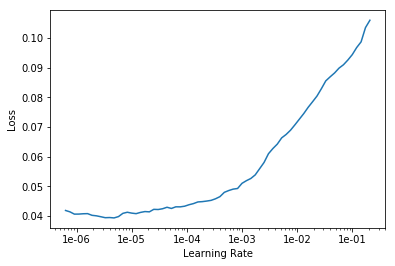

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.freeze()
learn.fit_one_cycle(20,1e-6)

epoch,train_loss,valid_loss,
1,0.039598,0.022646,0.922801
2,0.038575,0.024026,0.918974
3,0.038531,0.022163,0.925213
4,0.039661,0.023364,0.921659
5,0.039391,0.022716,0.922333
6,0.039150,0.021861,0.927915
7,0.040966,0.022847,0.924067
8,0.039498,0.022944,0.922754
9,0.039195,0.022300,0.924961
10,0.038637,0.022627,0.922703


In [74]:
learn.save('final1-299')

In [75]:
learn = learn.load('final1-299')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


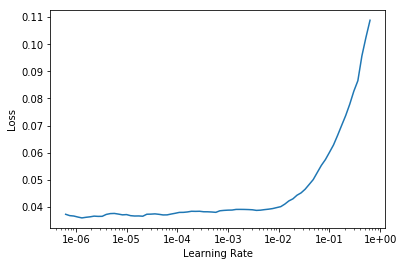

In [83]:
learn.lr_find()
learn.recorder.plot()


In [84]:
learn.freeze()

In [85]:
learn.fit_one_cycle(7,1e-5)

epoch,train_loss,valid_loss,
1,0.037155,0.023112,0.923633
2,0.037802,0.023637,0.921494
3,0.036122,0.024259,0.919882
4,0.037582,0.023054,0.923372
5,0.037853,0.022684,0.925429
6,0.036429,0.023363,0.922158
7,0.039177,0.023534,0.921902


In [73]:
learn.save('final2-299')

In [77]:
learn = learn.load('final2-299')

# Creating Submission

In [86]:
def denorm(im,bbox):
    shape =  im.size
    h = shape[0]
    w = shape[1]
    bbox = (bbox + 1)/2
    bbox[0] = bbox[0]*h
    bbox[2] = bbox[2]*h
    bbox[1] = bbox[1]*w
    bbox[3] = bbox[3]*w
    return bbox

In [87]:
test = pd.read_csv(path/'test.csv')
test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [88]:
def filltest(temppath):
    im = open_image(temppath)
    preds = learn.predict(im)
    preds = denorm(im,preds[2].numpy())
    y1,x1,y2,x2 = preds
    return x1,y1,x2,y2

In [89]:
for i,row in test.iterrows():
    p = row['image_name']
    x1,y1,x2,y2 = filltest(imgpath/p)
    test.at[i,'x1'] = x1
    test.at[i,'x2'] = x2
    test.at[i,'y1'] = y1
    test.at[i,'y2'] = y2

In [90]:
test = test.set_index('image_name')
test.to_csv('final6.csv')